In [1]:
import matplotlib.pyplot as plt
import polars as pl
import taxifare.data as data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import math

In [2]:
df = data.load_data().fetch(500_000)
# df = data.load_data().collect()

# Run preprocess.py to obtain the parquet dataset
# df = pl.read_parquet('datasets/train.parquet')
df.head()

shape: (5, 7)
┌─────────────┬────────────┬────────────┬────────────┬───────────────┬──────────────┬──────────────┐
│ fare_amount ┆ pickup_dat ┆ pickup_lon ┆ pickup_lat ┆ dropoff_longi ┆ dropoff_lati ┆ passenger_co │
│ ---         ┆ etime      ┆ gitude     ┆ itude      ┆ tude          ┆ tude         ┆ unt          │
│ f64         ┆ ---        ┆ ---        ┆ ---        ┆ ---           ┆ ---          ┆ ---          │
│             ┆ datetime[μ ┆ f64        ┆ f64        ┆ f64           ┆ f64          ┆ i64          │
│             ┆ s]         ┆            ┆            ┆               ┆              ┆              │
╞═════════════╪════════════╪════════════╪════════════╪═══════════════╪══════════════╪══════════════╡
│ 4.5         ┆ 2009-06-15 ┆ -73.844311 ┆ 40.721319  ┆ -73.84161     ┆ 40.712278    ┆ 1            │
│             ┆ 17:26:21   ┆            ┆            ┆               ┆              ┆              │
│ 16.9        ┆ 2010-01-05 ┆ -74.016048 ┆ 40.711303  ┆ -73.979268    ┆ 40.782004    ┆ 1            │
│             ┆ 16:52:16   ┆            ┆            ┆               ┆              ┆              │
│ 5.7         ┆ 2011-08-18 ┆ -73.982738 ┆ 40.76127   ┆ -73.991242    ┆ 40.750562    ┆ 2            │
│             ┆ 00:35:00   ┆            ┆            ┆               ┆              ┆              │
│ 7.7         ┆ 2012-04-21 ┆ -73.98713  ┆ 40.733143  ┆ -73.991567    ┆ 40.758092    ┆ 1            │
│             ┆ 04:30:42   ┆            ┆            ┆               ┆              ┆              │
│ 5.3         ┆ 2010-03-09 ┆ -73.968095 ┆ 40.768008  ┆ -73.956655    ┆ 40.783762    ┆ 1            │
│             ┆ 07:51:00   ┆            ┆            ┆               ┆              ┆              │
└─────────────┴────────────┴────────────┴────────────┴───────────────┴──────────────┴──────────────┘

In [3]:
df.shape

(10000000, 7)

## Data distribution

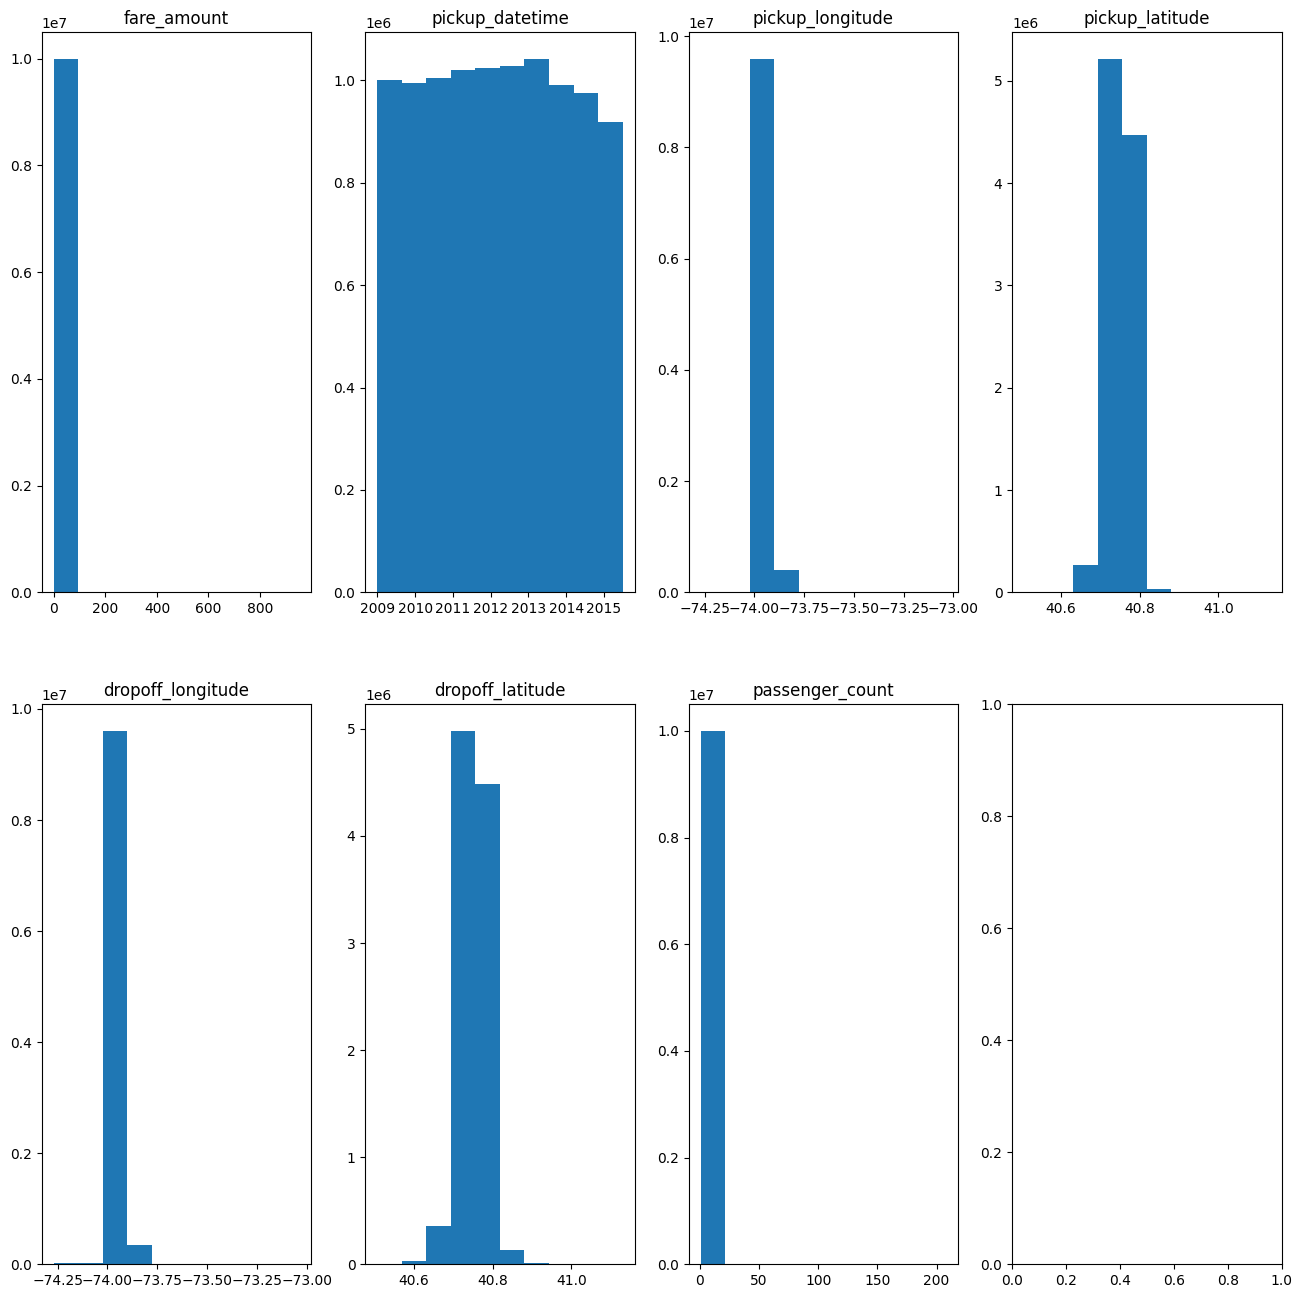

In [4]:
# NB: This plot takes a lot of time
data.plot_distributions(df)

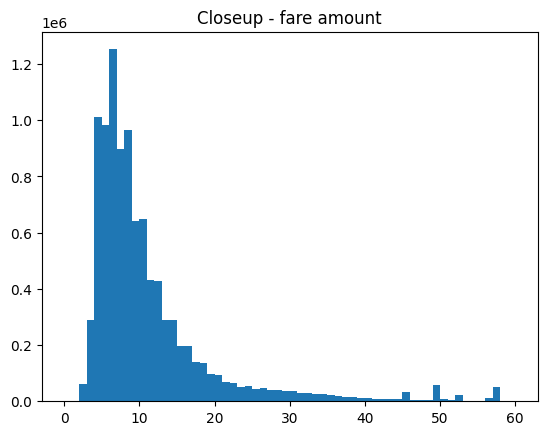

In [5]:
plt.hist(df['fare_amount'], bins=60, range=(0, 60))
plt.title('Closeup - fare amount')
plt.show()

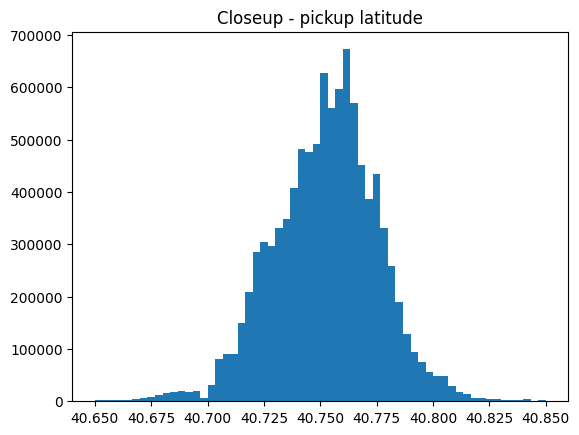

In [6]:
plt.hist(df['pickup_latitude'], bins=60, range=(40.65, 40.85))
plt.title('Closeup - pickup latitude')
plt.show()

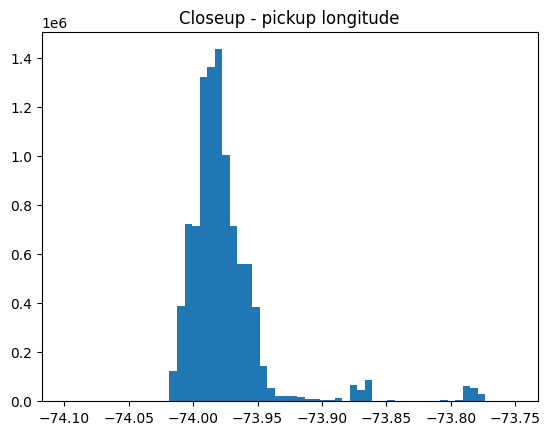

In [7]:
plt.hist(df['pickup_longitude'], bins=60, range=(-74.1, -73.75))
plt.title('Closeup - pickup longitude')
plt.show()

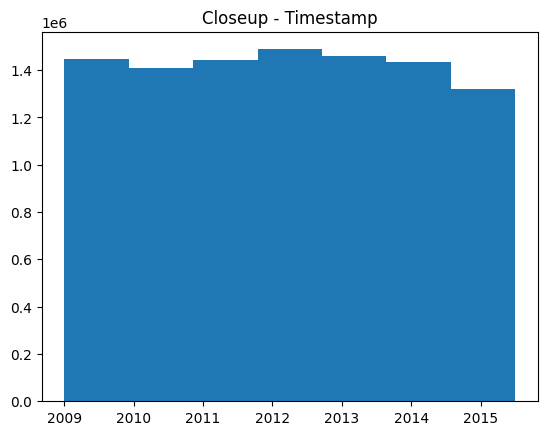

In [8]:
plt.hist(df['pickup_datetime'], bins=7)
plt.title('Closeup - Timestamp')
plt.show()

The distributions suggest the existence of unrealistic data (noise?) and outliers (hundres of passengers for one run, thosands of dollars for a single run). Min and max values show this very clearly. Before moving on with other statistics, it may be a good idea to clear the data further.

In [9]:
df.describe()

shape: (7, 8)
┌────────┬───────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ descri ┆ fare_amou ┆ pickup_dat ┆ pickup_lon ┆ pickup_lat ┆ dropoff_lo ┆ dropoff_la ┆ passenger_ │
│ be     ┆ nt        ┆ etime      ┆ gitude     ┆ itude      ┆ ngitude    ┆ titude     ┆ count      │
│ ---    ┆ ---       ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str    ┆ f64       ┆ str        ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ count  ┆ 1e7       ┆ 10000000   ┆ 1e7        ┆ 1e7        ┆ 1e7        ┆ 1e7        ┆ 1e7        │
│ null_c ┆ 0.0       ┆ 0          ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ ount   ┆           ┆            ┆            ┆            ┆            ┆            ┆            │
│ mean   ┆ 11.318689 ┆ null       ┆ -73.975413 ┆ 40.750861  ┆ -73.974493 ┆ 40.751271  ┆ 1.6907683  │
│ std    ┆ 9.627206  ┆ null       ┆ 0.034985   ┆ 0.027074   ┆ 0.034746   ┆ 0.030997   ┆ 1.311871   │
│ min    ┆ 0.01      ┆ 2009-01-01 ┆ -74.268085 ┆ 40.507085  ┆ -74.268085 ┆ 40.507043  ┆ 1.0        │
│        ┆           ┆ 00:00:46.0 ┆            ┆            ┆            ┆            ┆            │
│        ┆           ┆ 00000      ┆            ┆            ┆            ┆            ┆            │
│ max    ┆ 952.0     ┆ 2015-06-30 ┆ -73.036997 ┆ 41.130295  ┆ -73.0383   ┆ 41.12971   ┆ 208.0      │
│        ┆           ┆ 23:59:54.0 ┆            ┆            ┆            ┆            ┆            │
│        ┆           ┆ 00000      ┆            ┆            ┆            ┆            ┆            │
│ median ┆ 8.5       ┆ null       ┆ -73.982105 ┆ 40.753345  ┆ -73.98061  ┆ 40.753857  ┆ 1.0        │
└────────┴───────────┴────────────┴────────────┴────────────┴────────────┴────────────┴────────────┘

### Passenger count
According to the [NYC taxi commission](https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page#:~:text=The%20maximum%20amount%20of%20passengers,of%20an%20adult%20passenger%20seated) the maximum number of passengers, for suitable vehicles, is five. An additional sixth person (child) is admitted. Thus, it is possible to consider all samples that exceed the number of six passengers to be noise. In fact, values greater than six are highly underrepresented.

In [10]:
df.groupby('passenger_count').agg(pl.count()).sort('passenger_count')

shape: (11, 2)
┌─────────────────┬─────────┐
│ passenger_count ┆ count   │
│ ---             ┆ ---     │
│ i64             ┆ u32     │
╞═════════════════╪═════════╡
│ 1               ┆ 6939855 │
│ 2               ┆ 1483768 │
│ 3               ┆ 440933  │
│ 4               ┆ 213146  │
│ ...             ┆ ...     │
│ 8               ┆ 1       │
│ 9               ┆ 3       │
│ 129             ┆ 1       │
│ 208             ┆ 3       │
└─────────────────┴─────────┘

In [11]:
df = df.filter(pl.col('passenger_count') <= 6)

## Analyzing spatial locations

In [12]:
# train, test = train_test_split(df, test_size=0.2)
# train, valid = train_test_split(train, test_size=0.2)

In [13]:
def print_point_on_map(ax, x, y, points_area, image, markersize=.5, color='b', title=None):
    left, right, bottom, top = points_area
    ax.imshow(image, extent=(left, right, bottom, top))
    ax.set_ylim(bottom, top)
    ax.set_xlim(left, right)
    ax.scatter(x, y, markersize, color)
    if title is not None:
        ax.title.set_text(str(title))

Using cached image


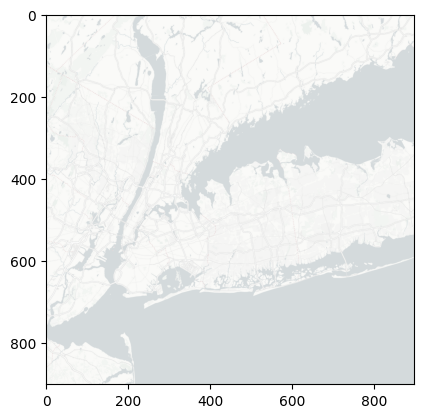

(-74.268085, -73.036997, 40.35065861267229, 41.28667938732771)


In [14]:
x = df['pickup_longitude'].append(df['dropoff_longitude'])
y = df['pickup_latitude'].append(df['dropoff_latitude'])
points_area = x.min(), x.max(), y.min(), y.max()

# Make the area a square
width = data.distance((points_area[0],points_area[2]), (points_area[1],points_area[2]))
height = data.distance((points_area[0],points_area[2]), (points_area[0],points_area[3]))

additional_space = (width - height)/2

new_lat_min, _ = data.find_latitude_correction((points_area[0],points_area[2]), additional_space, b=-1)
new_lat_max, _ = data.find_latitude_correction((points_area[0],points_area[3]), additional_space, b=1)

points_area = points_area[0], points_area[1], new_lat_min, new_lat_max
# print(data.distance((points_area[0],points_area[2]), (points_area[1],points_area[2])))
# print(data.distance((points_area[1],points_area[2]), (points_area[1],points_area[3])))
# print(data.distance((points_area[1],points_area[3]), (points_area[0],points_area[3])))
# print(data.distance((points_area[0],points_area[3]), (points_area[0],points_area[2])))

url = 'https://b.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'
image = data.new_york_map(points_area)

plt.imshow(image)
plt.show()
print(points_area)

In [15]:
# Remove points on ocean, not working at the moment
ocean_pickup = df.select(
    pl.struct(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
    .map(data.polars_point_on_ocean(points_area, pickup=True))
    ).get_columns()[0].alias('ocean_pickup')
print("pickup done")
ocean_dropoff = df.select(
    pl.struct(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
    .map(data.polars_point_on_ocean(points_area, dropoff=True))
    ).get_columns()[0].alias('ocean_dropoff')

print('Pickups in the ocean', ocean_pickup.arg_true().shape[0])
print('Dropoffs in the ocean', ocean_dropoff.arg_true().shape[0])
print('Total ocean outlier samples',
      (ocean_dropoff | ocean_pickup).arg_true().shape[0])

outsiders_pickup = df.filter(ocean_pickup)
outsiders_dropoff = df.filter(ocean_dropoff)

pickup done
Pickups in the ocean 15295
Dropoffs in the ocean 20089
Total ocean outlier samples 30847


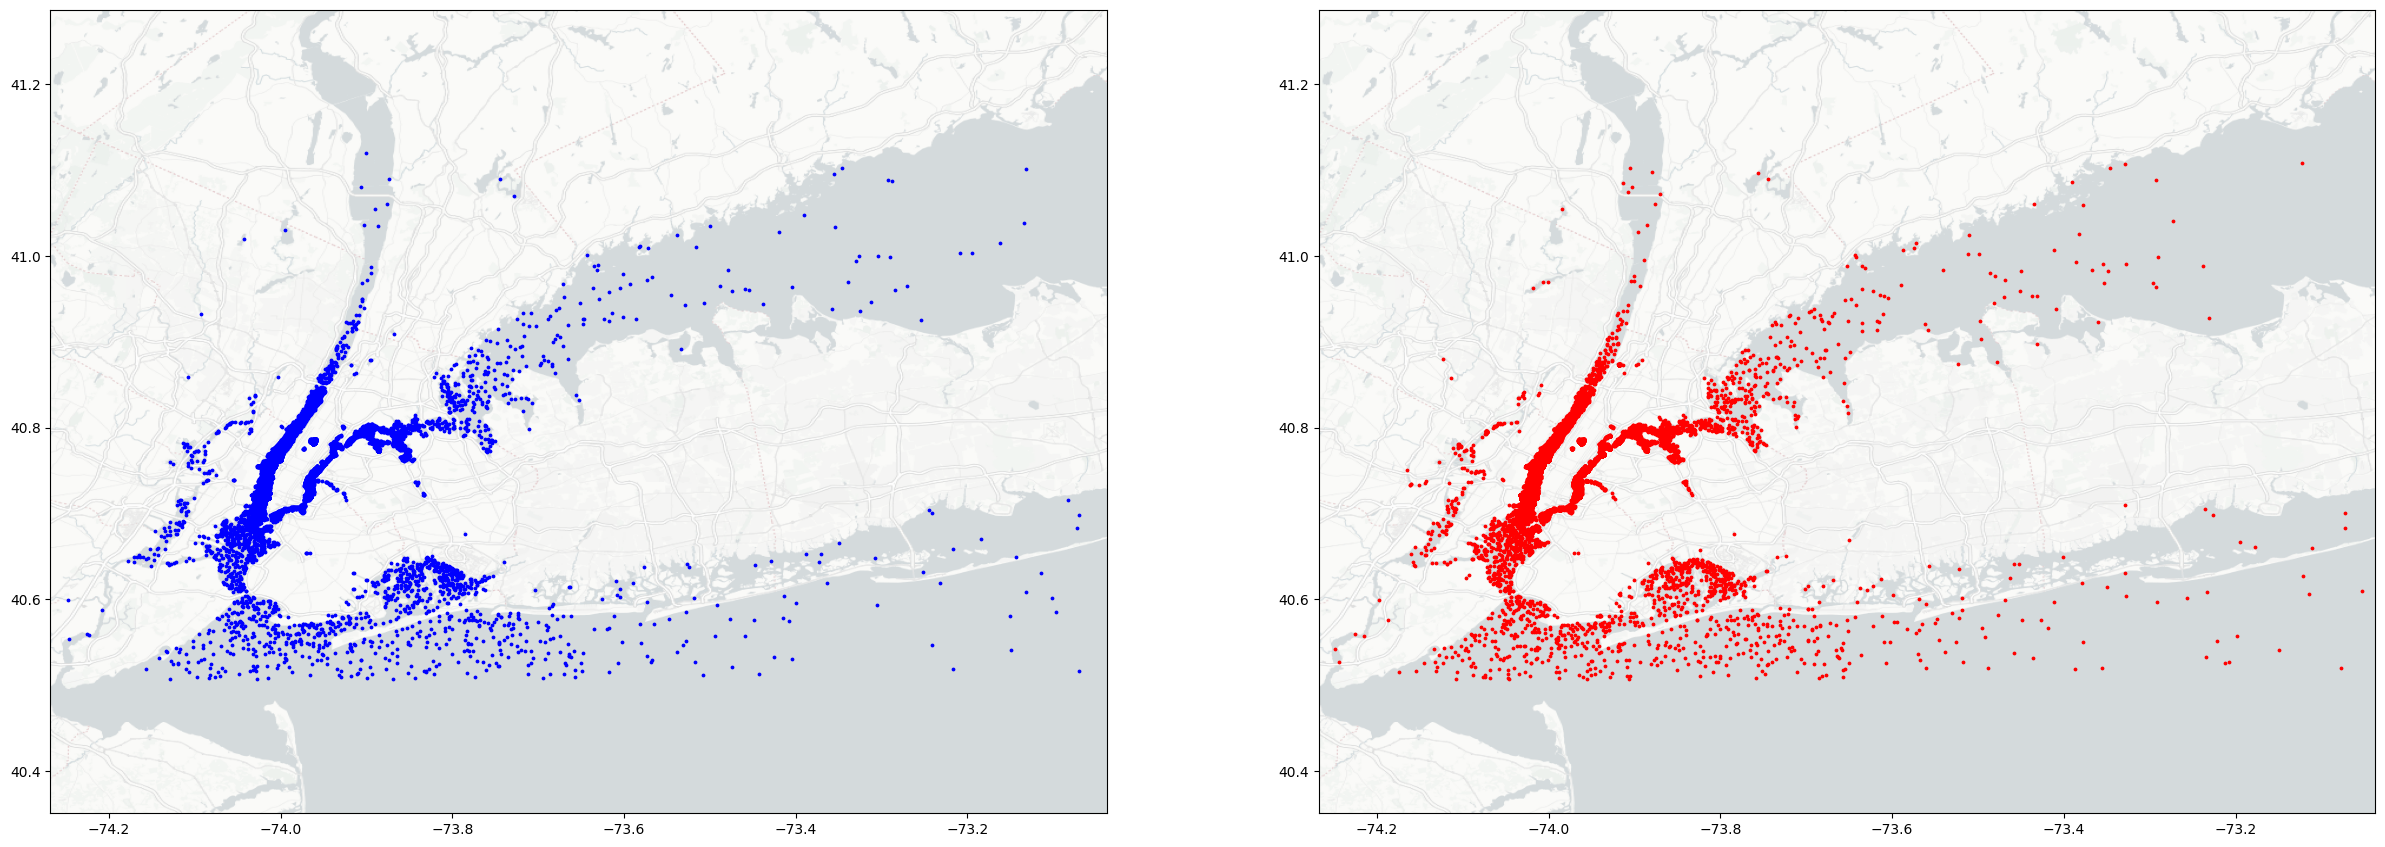

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(30, 30))

print_point_on_map(axs[0], outsiders_pickup['pickup_longitude'], outsiders_pickup['pickup_latitude'], points_area, image, color='b', markersize=3)
print_point_on_map(axs[1], outsiders_dropoff['dropoff_longitude'], outsiders_dropoff['dropoff_latitude'], points_area, image, color='r', markersize=3)

In [17]:
df = df.filter(~ocean_pickup & ~ocean_dropoff)

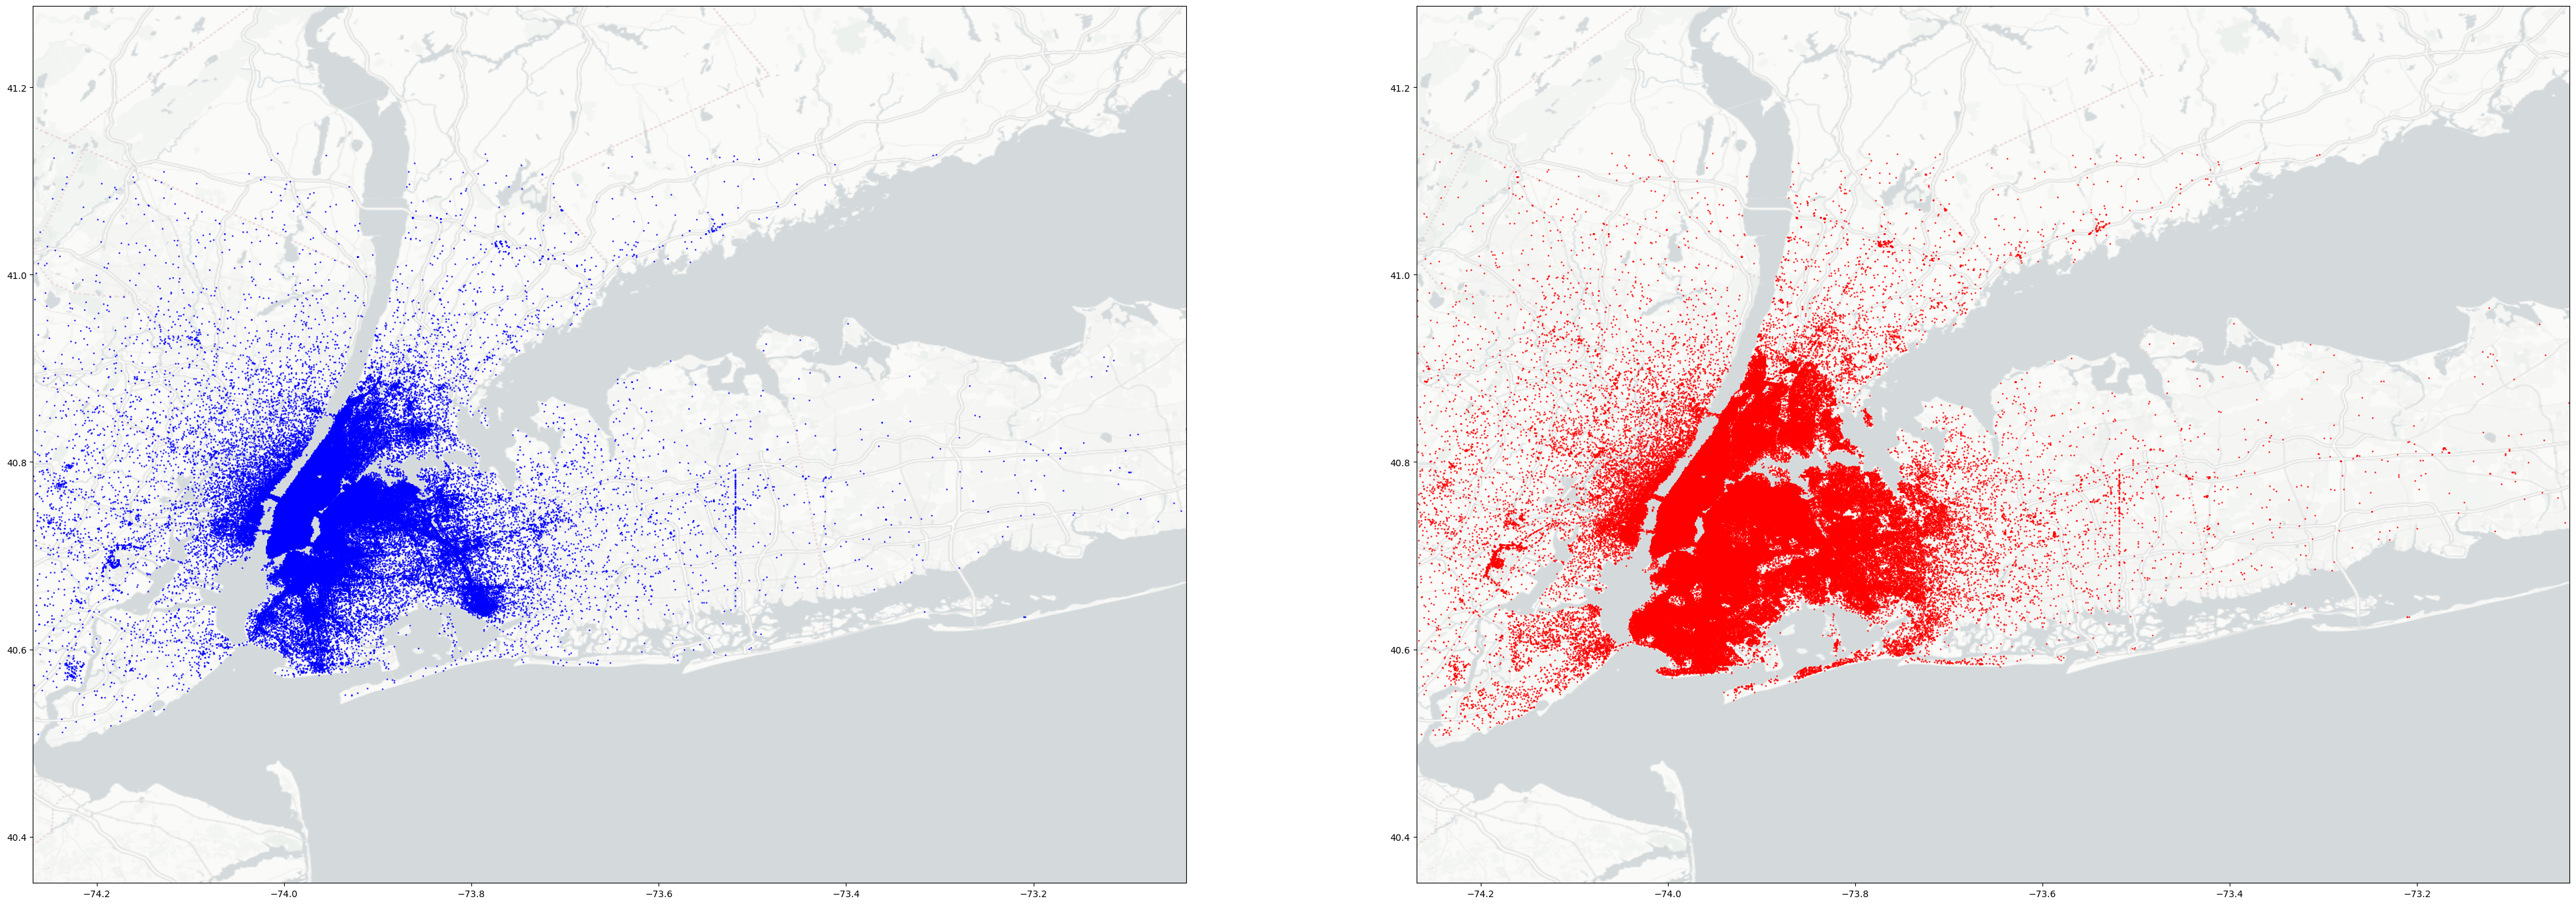

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(50, 50))
print_point_on_map(axs[0], df['pickup_longitude'], df['pickup_latitude'], points_area, image, color='b')
print_point_on_map(axs[1], df['dropoff_longitude'], df['dropoff_latitude'], points_area, image, color='r')

3098871 6870272


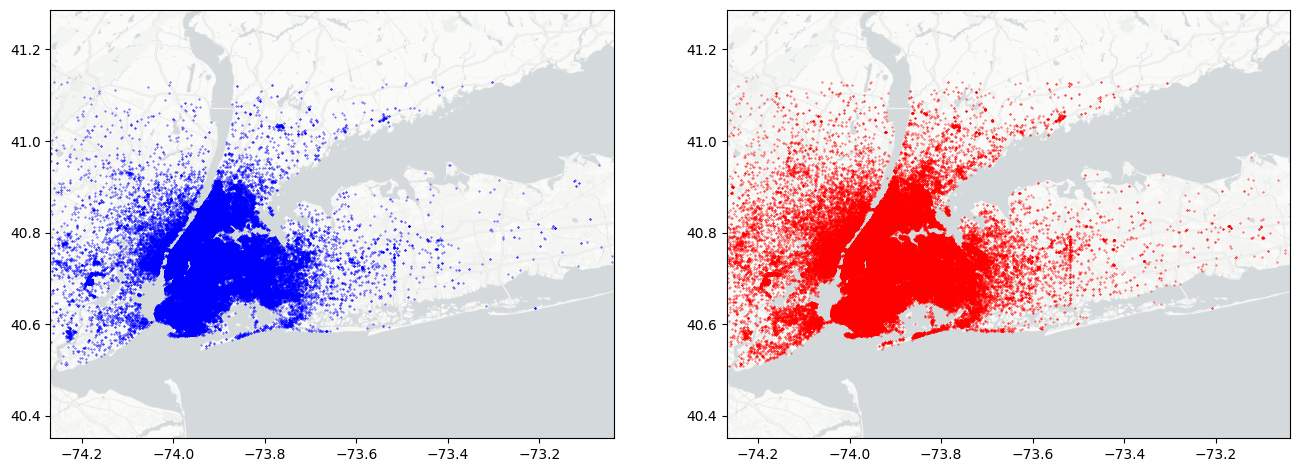

In [19]:
timezone = -5
lavorative_hours = (8, 18)

day_hours = df.filter((pl.col("pickup_datetime").dt.hour() > lavorative_hours[0]+timezone) & (pl.col("pickup_datetime").dt.hour() < lavorative_hours[1]+timezone))
night_hours = df.filter((pl.col("pickup_datetime").dt.hour() <= lavorative_hours[0]+timezone) | (pl.col("pickup_datetime").dt.hour() >= lavorative_hours[1]+timezone))

print(len(day_hours), len(night_hours))

x_day = day_hours['pickup_longitude'].append(day_hours['dropoff_longitude'])
y_day = day_hours['pickup_latitude'].append(day_hours['dropoff_latitude'])

x_night = night_hours['pickup_longitude'].append(night_hours['dropoff_longitude'])
y_night = night_hours['pickup_latitude'].append(night_hours['dropoff_latitude'])

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
print_point_on_map(axs[0], x_day, y_day, points_area, image, color='b', markersize=0.1)
print_point_on_map(axs[1], x_night, y_night, points_area, image, color='r', markersize=0.1)

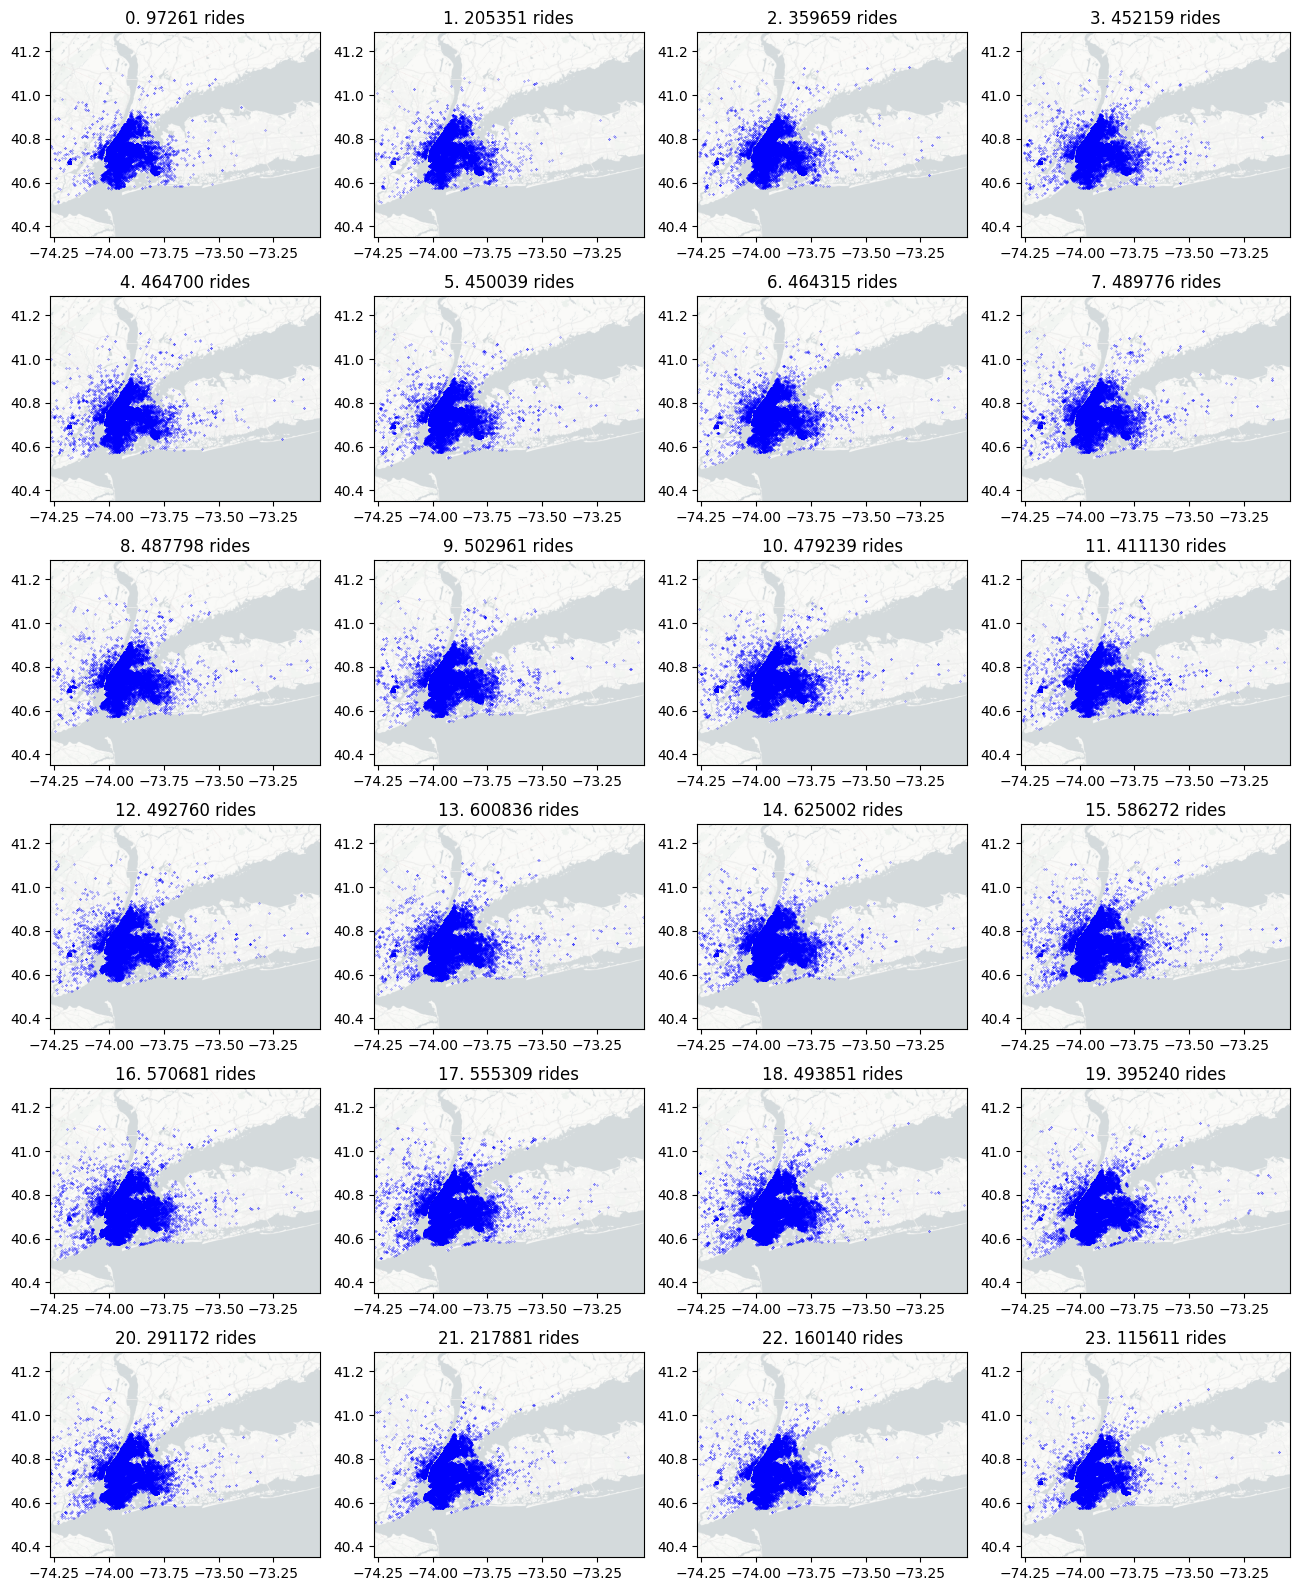

In [20]:
hours = []

for h in range(5,29):
    hour_df = df.filter(pl.col("pickup_datetime").dt.hour() == h % 24)
    hours.append((hour_df['pickup_longitude'].append(hour_df['dropoff_longitude']),
                  hour_df['pickup_latitude'].append(hour_df['dropoff_latitude']),
                  len(hour_df)))
    
fig, axs = plt.subplots(6, 4, figsize=(16, 20))
for h in range(24):
    print_point_on_map(axs[h//4, h % 4], hours[h][0], hours[h][1], points_area, image, color='b',
                       title=f'{(h) % 24}. {hours[h][2]} rides', markersize=0.05)

## Time
Specific features have to be extracted from timestamps, based on periods and trends.

### Monthly-Yearly trend

The first thing to investigate is the presence of trends, as detrending data will eventually be necessary before looking for periods. Public transportation rarely becomes cheaper, (at least, that how it is in Bologna). The NYC taxi data spans for about six years, hence, let us look for a yearly trend

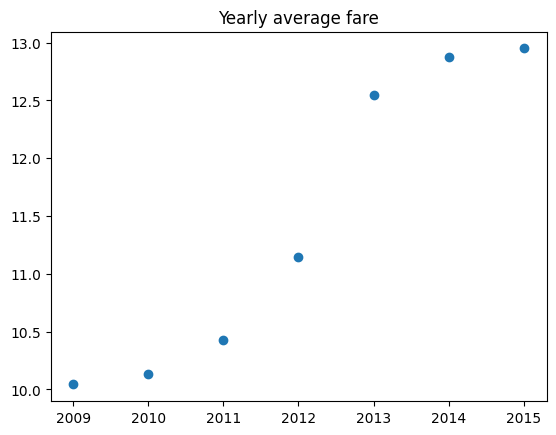

In [21]:
plt.scatter(
    *df.select(['pickup_datetime', 'fare_amount']).sort('pickup_datetime')
    .groupby_dynamic('pickup_datetime', every='1y')
    .agg(pl.mean('fare_amount'))
    .get_columns())
plt.title('Yearly average fare')
plt.show()

In [22]:
df.select(['pickup_datetime', 'fare_amount']).sort('pickup_datetime') \
  .groupby_dynamic('pickup_datetime', every='1y') \
  .agg(pl.col('fare_amount').std().alias('std'))

shape: (7, 2)
┌─────────────────────┬───────────┐
│ pickup_datetime     ┆ std       │
│ ---                 ┆ ---       │
│ datetime[μs]        ┆ f64       │
╞═════════════════════╪═══════════╡
│ 2009-01-01 00:00:00 ┆ 8.146008  │
│ 2010-01-01 00:00:00 ┆ 8.310559  │
│ 2011-01-01 00:00:00 ┆ 8.648179  │
│ 2012-01-01 00:00:00 ┆ 9.372256  │
│ 2013-01-01 00:00:00 ┆ 10.582376 │
│ 2014-01-01 00:00:00 ┆ 11.004761 │
│ 2015-01-01 00:00:00 ┆ 11.344783 │
└─────────────────────┴───────────┘

Even though variance is pretty high, there is an unambiguous yearly trend (NYC is not that different from Bologna after all). In fact, it is a well known fact that public transportation fares in NYC have been adjusted over time to deal with inflation [2]. In particular, a notable increase happened between 2012 and 2013.

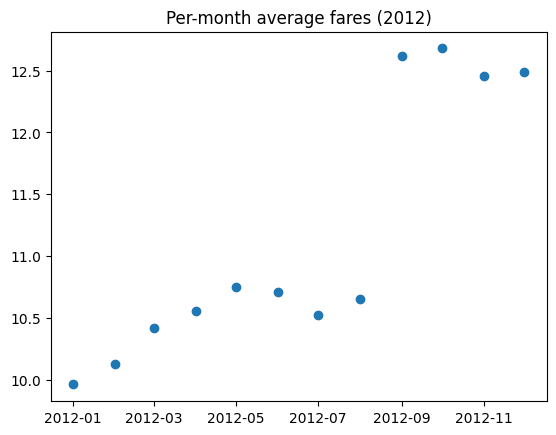

In [23]:
plt.scatter(
    *df.select(['pickup_datetime', 'fare_amount']).sort('pickup_datetime')
    .filter(pl.col('pickup_datetime').dt.year() == 2012)
    .groupby_dynamic('pickup_datetime', every='1mo')
    .agg(pl.mean('fare_amount'))
    .get_columns())
plt.title('Per-month average fares (2012)')
plt.show()

Further inspection shows that the gap happened in September 2012. In fact, historical record witnesses this. According to the *Fare and Lease Cap Report* of April 2013 [3], during fall 2012 fares have increased by 17%, apparently in order to handle a change in credit card processing fees.

Approximating the trend is mandatory in order to proceed with the inspection of periods. Given its nature (inflation) it is acceptable to consider it linear. However, the big gap of September 2012 can be considered anomalous and would clearly skew the linear coefficients. For this reason, two linear trends are considered, with a discontinuity exactly in September 2012.

In [24]:
# Compute the monthly average fares and split them before/after Sep 2012
date_threshold = pl.datetime(2012, 9, 1)

months_df = (
    df.select(['pickup_datetime', 'fare_amount'])
    .sort('pickup_datetime')
    .groupby_dynamic('pickup_datetime', every='1mo')
    .agg(pl.mean('fare_amount'))
)

months_pre2012_df = (
    months_df.filter(pl.col('pickup_datetime') < date_threshold)
)

months_post2012_df = (
    months_df.filter(pl.col('pickup_datetime') >= date_threshold)
)

# Sanity check on the dataframe shapes
split_month_span = len(months_pre2012_df) + len(months_post2012_df)
assert split_month_span == len(months_df)

print('Total months', split_month_span)
print('Months before Sep 2012:', len(months_pre2012_df))
print('Months after Sep 2012:', len(months_post2012_df))

Total months 78
Months before Sep 2012: 44
Months after Sep 2012: 34


In [25]:
# Fit two OLS regressors
months_features = np.array(range(len(months_df))).reshape(-1, 1)
months_pre2012_features = months_features[:len(months_pre2012_df)]
months_post2012_features = months_features[len(months_pre2012_df):]

trend_pre2012_regressor = LinearRegression(n_jobs=-1).fit(
    months_pre2012_features, months_pre2012_df['fare_amount'])
trend_post2012_regressor = LinearRegression(n_jobs=-1).fit(
    months_post2012_features, months_post2012_df['fare_amount'])

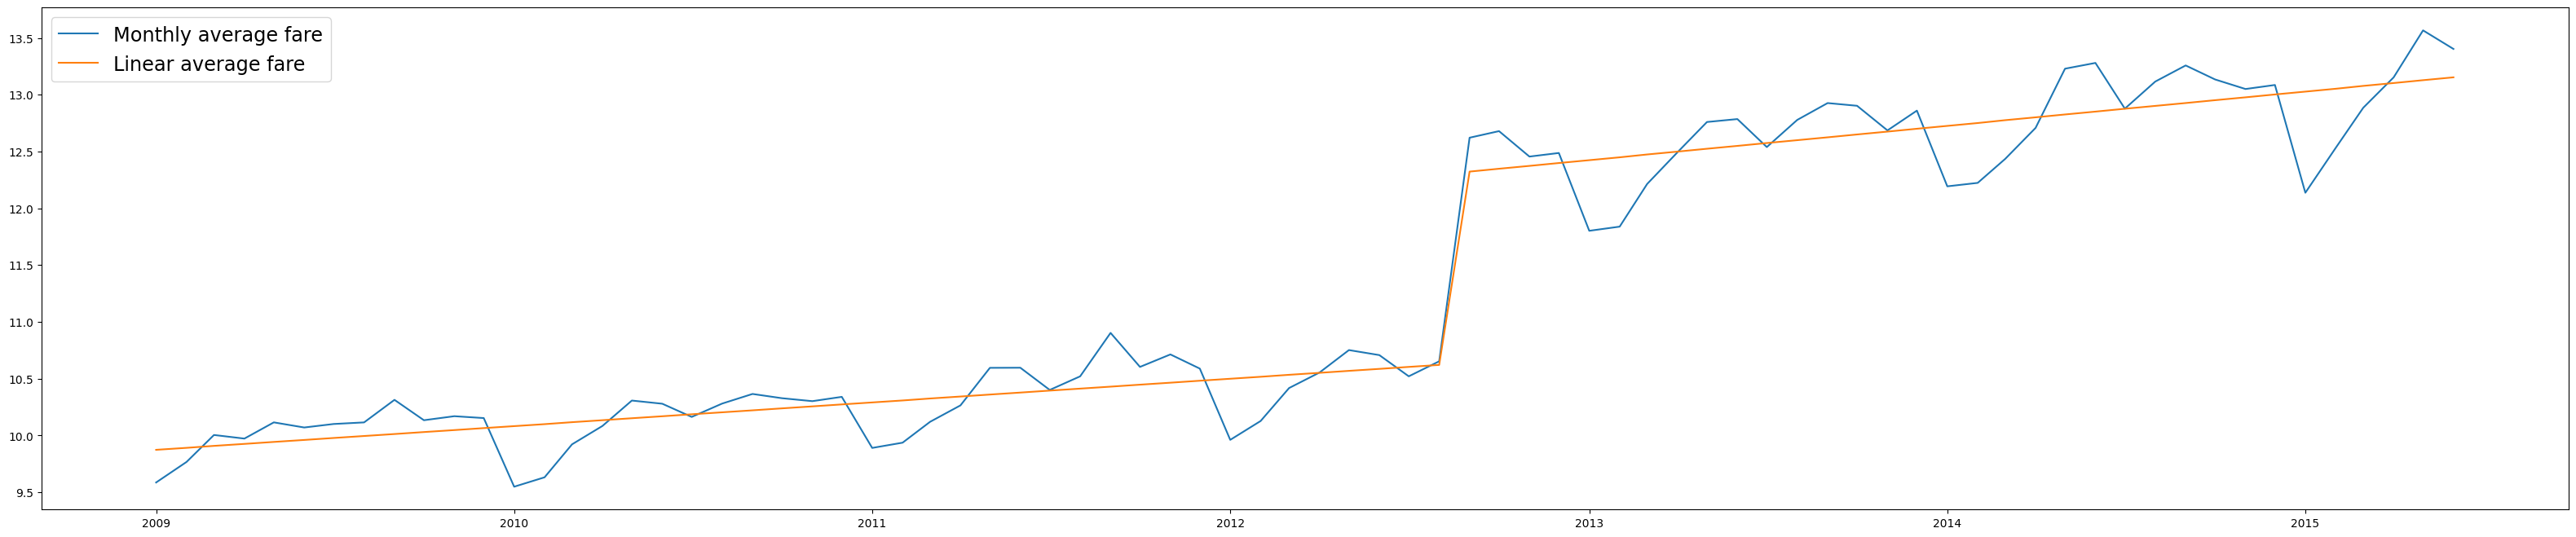

In [26]:
trend_pre2012_pred = trend_pre2012_regressor.predict(months_pre2012_features)
trend_post2012_pred = trend_post2012_regressor.predict(months_post2012_features)

plt.figure(figsize=(40, 8))
plt.plot(*months_df.get_columns())
plt.plot(months_df['pickup_datetime'],  np.concatenate((trend_pre2012_pred, trend_post2012_pred)))
plt.legend(('Monthly average fare', 'Linear average fare'), fontsize='xx-large')
plt.show()

The double-linear regression seems to be quite reasonable. This shall result in the extraction of a couple of dedicated features from the timestamps. However, which ones exactly will be discussed after an analysis on periods.

### Periods
A detrended/stationary series can now be computed in order to have a cleaner overview of the periods.

Starting with the already considered monthly data, detrending exposes clear seasonality. High variance of the computed averages makes the patterns a bit noisy but still, there is a noticeable drop in fares around january each year.

Apparently, the city slows down after the holidays, or at least this is what locals suggest [5]. Less demand means less traffic, which results is shorter traversal times and lower average fares (that is, excluding the hypothesis of winter specific fares).

Clearly, similar reasoning holds for high season fares (more demand, more traffic). 

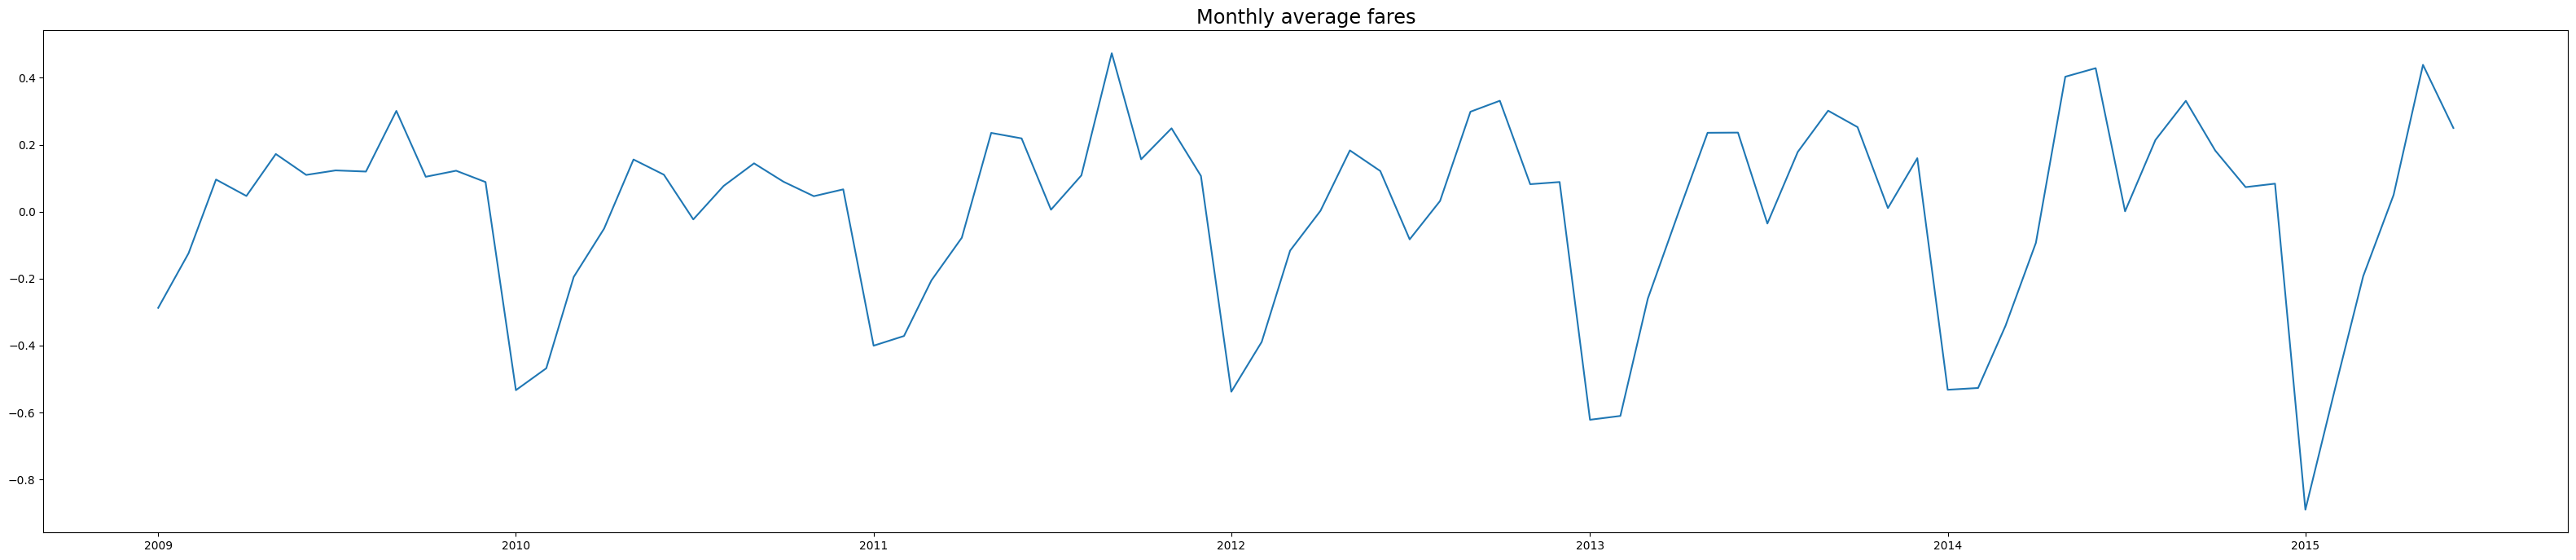

In [77]:
plt.figure(figsize=(40, 8))
plt.plot(*data.detrend(months_df, trend_pre2012_regressor,
                       trend_post2012_regressor, date_threshold)
         .get_columns())
plt.title('Monthly average fares',
          fontsize='xx-large')
plt.show()

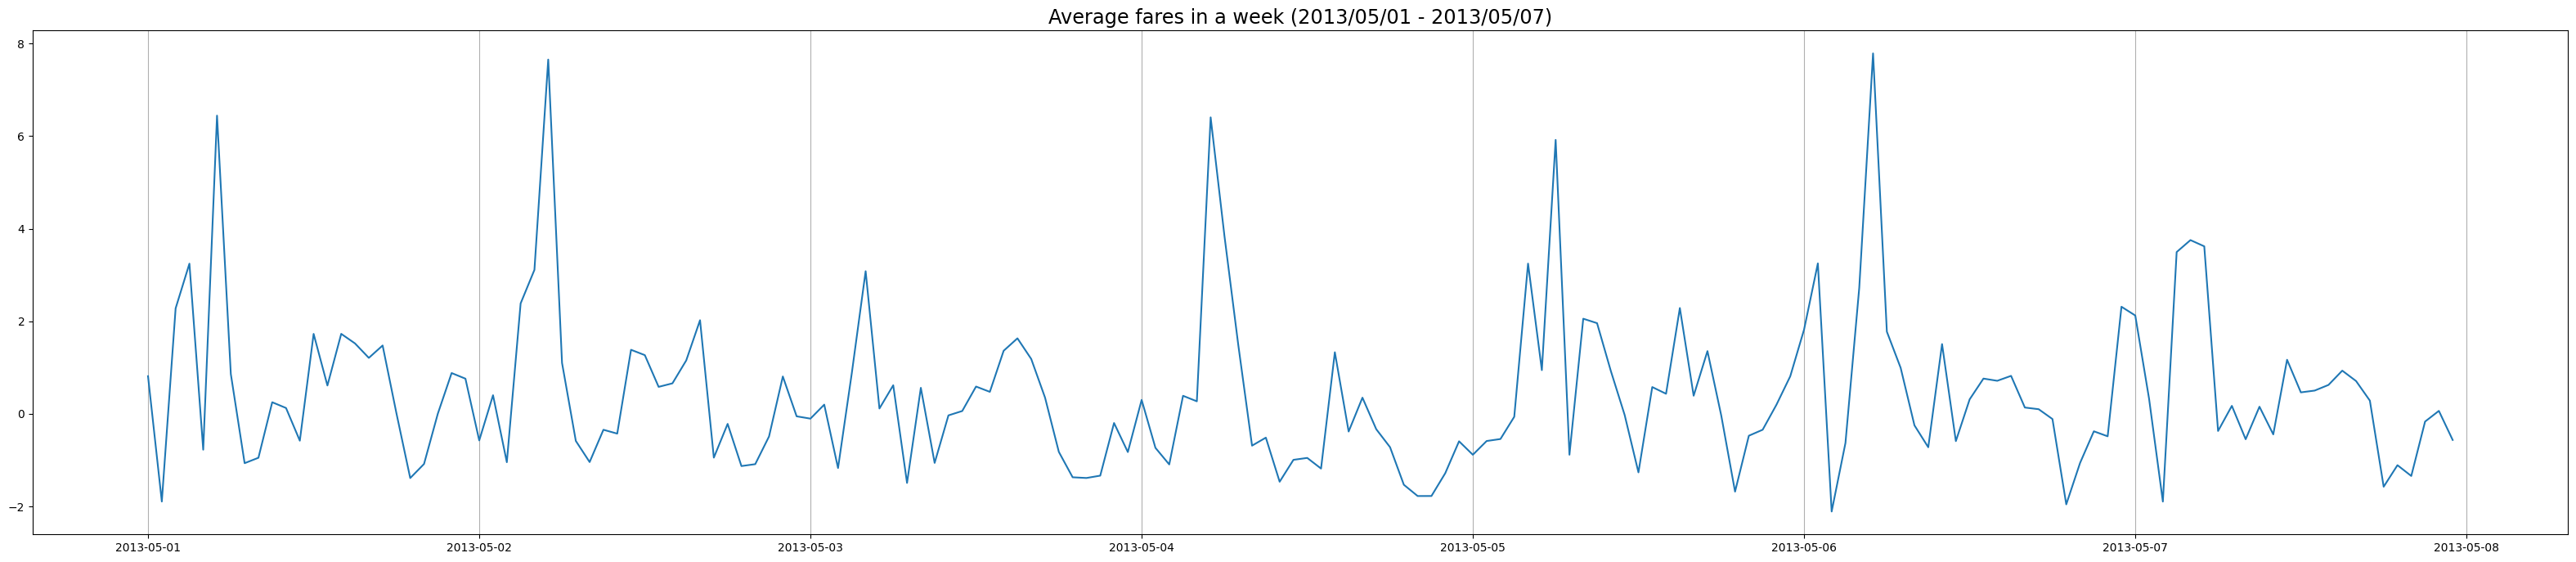

In [75]:
# NB: Inlcude at least 10mln samples to see the period

hours_df = (
    df.select(['pickup_datetime', 'fare_amount'])
    .sort('pickup_datetime')
    .groupby_dynamic('pickup_datetime', every='1h')
    .agg(pl.mean('fare_amount'))
)

# Show period on a certain number of days
from_date = pl.datetime(2013, 5, 1)
num_of_days = 7

plt.figure(figsize=(40, 8))
plt.plot(*data.detrend(hours_df, trend_pre2012_regressor,
                       trend_post2012_regressor, date_threshold)
         .filter(pl.col('pickup_datetime') >= from_date)
         [: num_of_days * 24]
         .get_columns())
plt.grid(axis='x')
plt.title('Average fares in a week (2013/05/01 - 2013/05/07)',
          fontsize='xx-large')
plt.show()

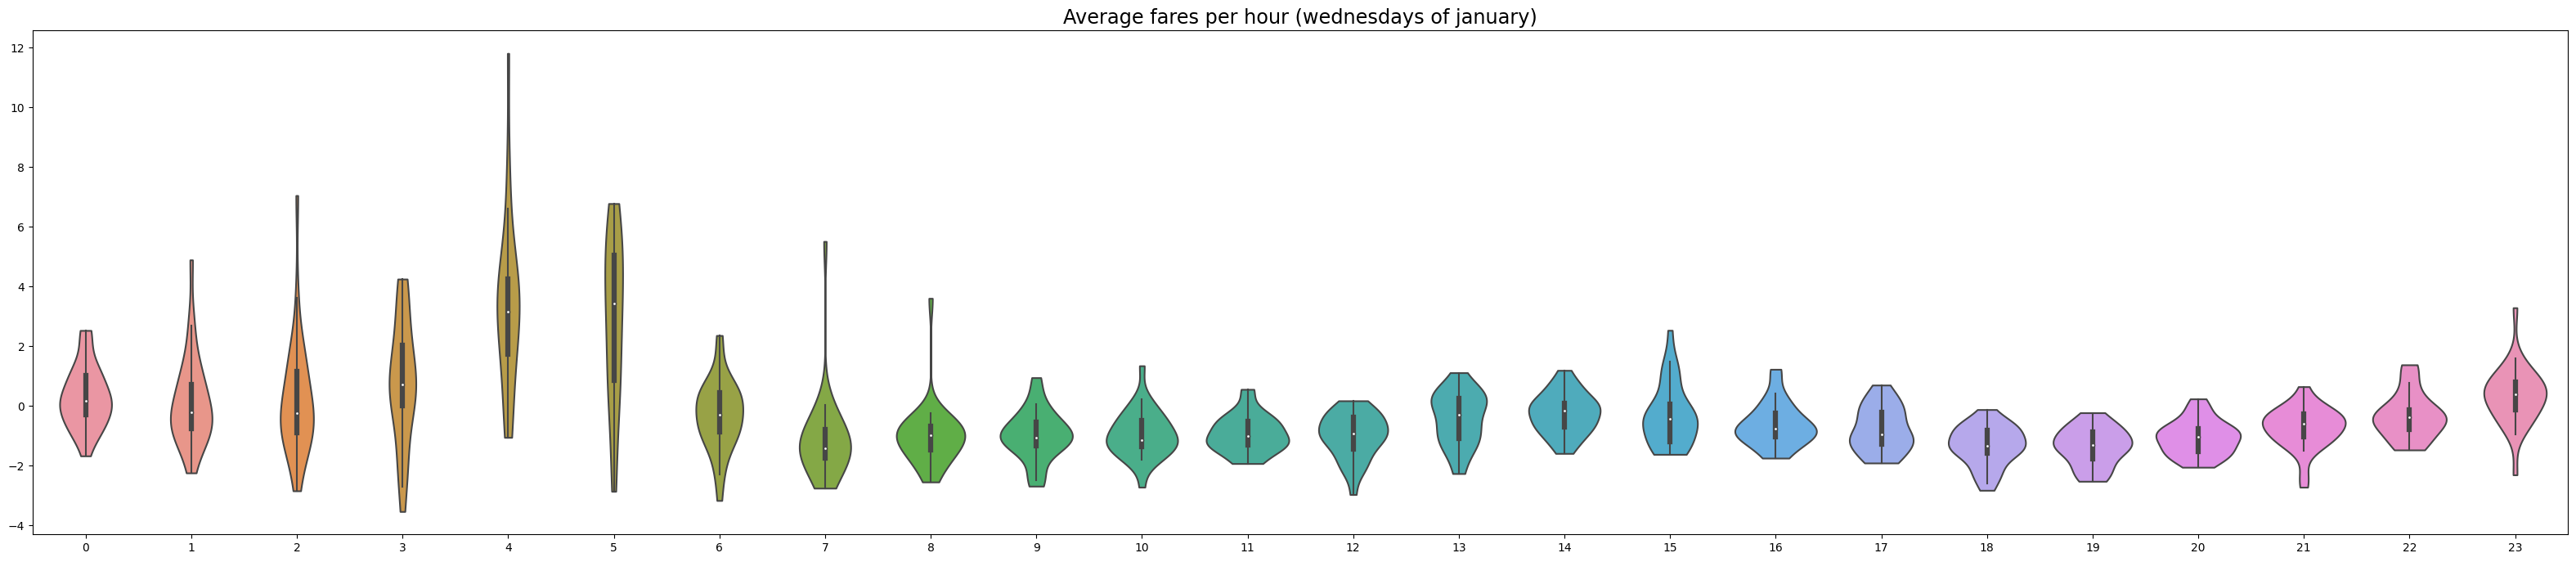

In [76]:
plt.figure(figsize=(40, 8))

axes = (data.detrend(hours_df, trend_pre2012_regressor,
                            trend_post2012_regressor, date_threshold)
        .filter((pl.col('pickup_datetime').dt.weekday() == 3) & (pl.col('pickup_datetime').dt.month() == 1))
        .select([pl.col('pickup_datetime').dt.hour(), 'fare_amount']).get_columns())

sns.violinplot(x=axes[0].to_numpy(), y=axes[1].to_numpy(), cut=0)
plt.title('Average fares per hour (wednesdays of january)',
          fontsize='xx-large')
plt.show()

/tmp/ipykernel_214050/1326602341.py:6: DeprecationWarning: `with_column` has been deprecated in favor of `with_columns`. This method will be removed in version 0.17.0
  df_grt_2013 = df_grt_2013.with_column(pl.col("pickup_datetime").dt.hour().alias('pickup_hour'))


Number of samples from or to jfk: 27926
Number of samples from or to manhattan: 558942


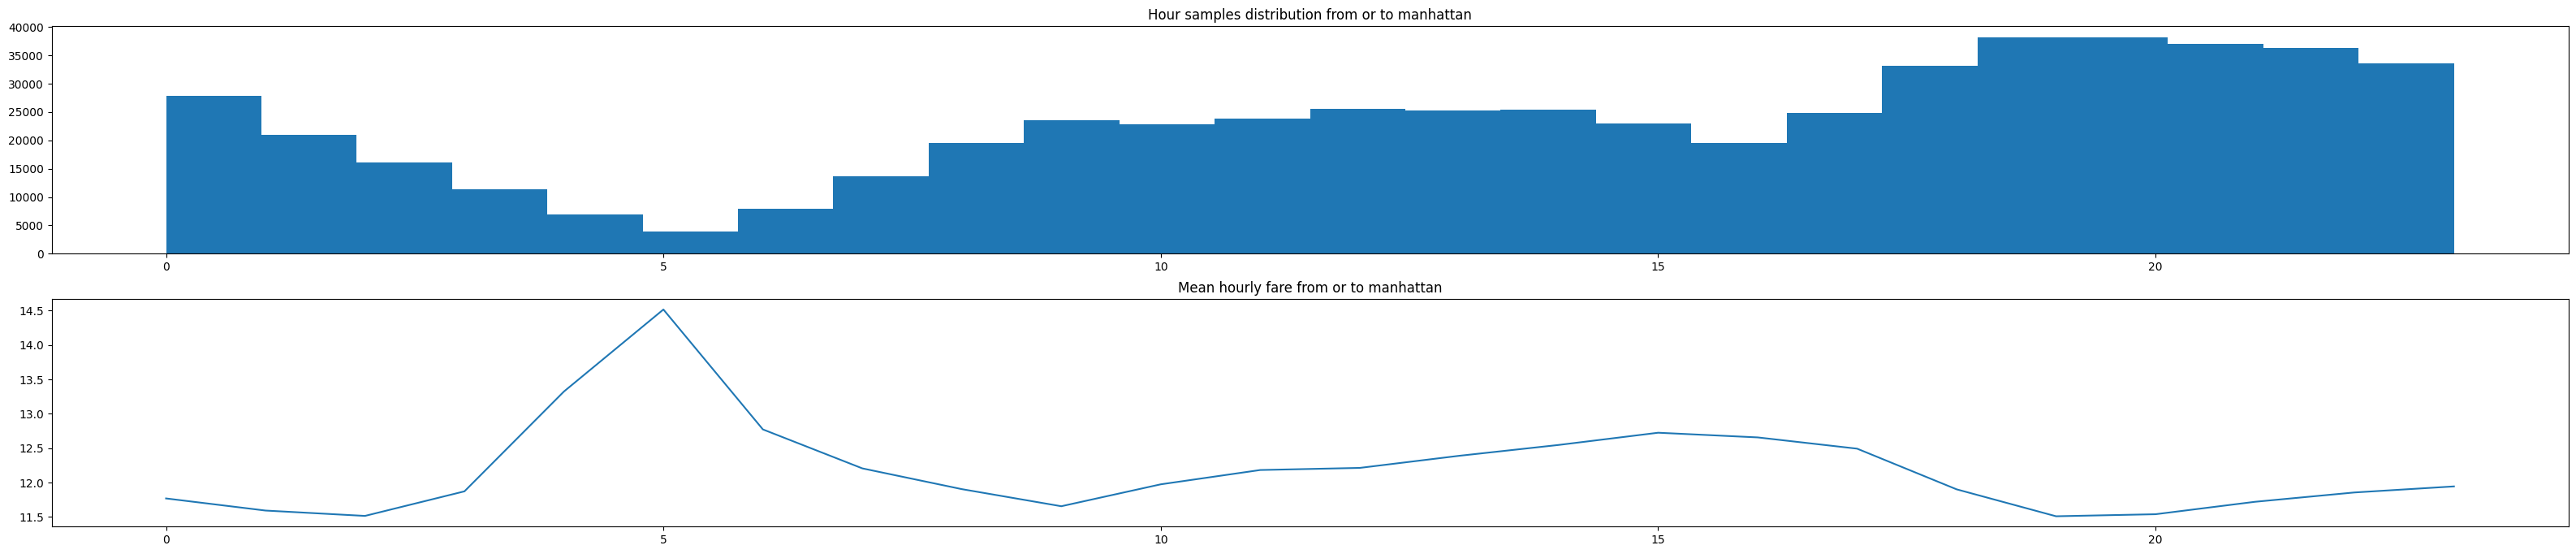

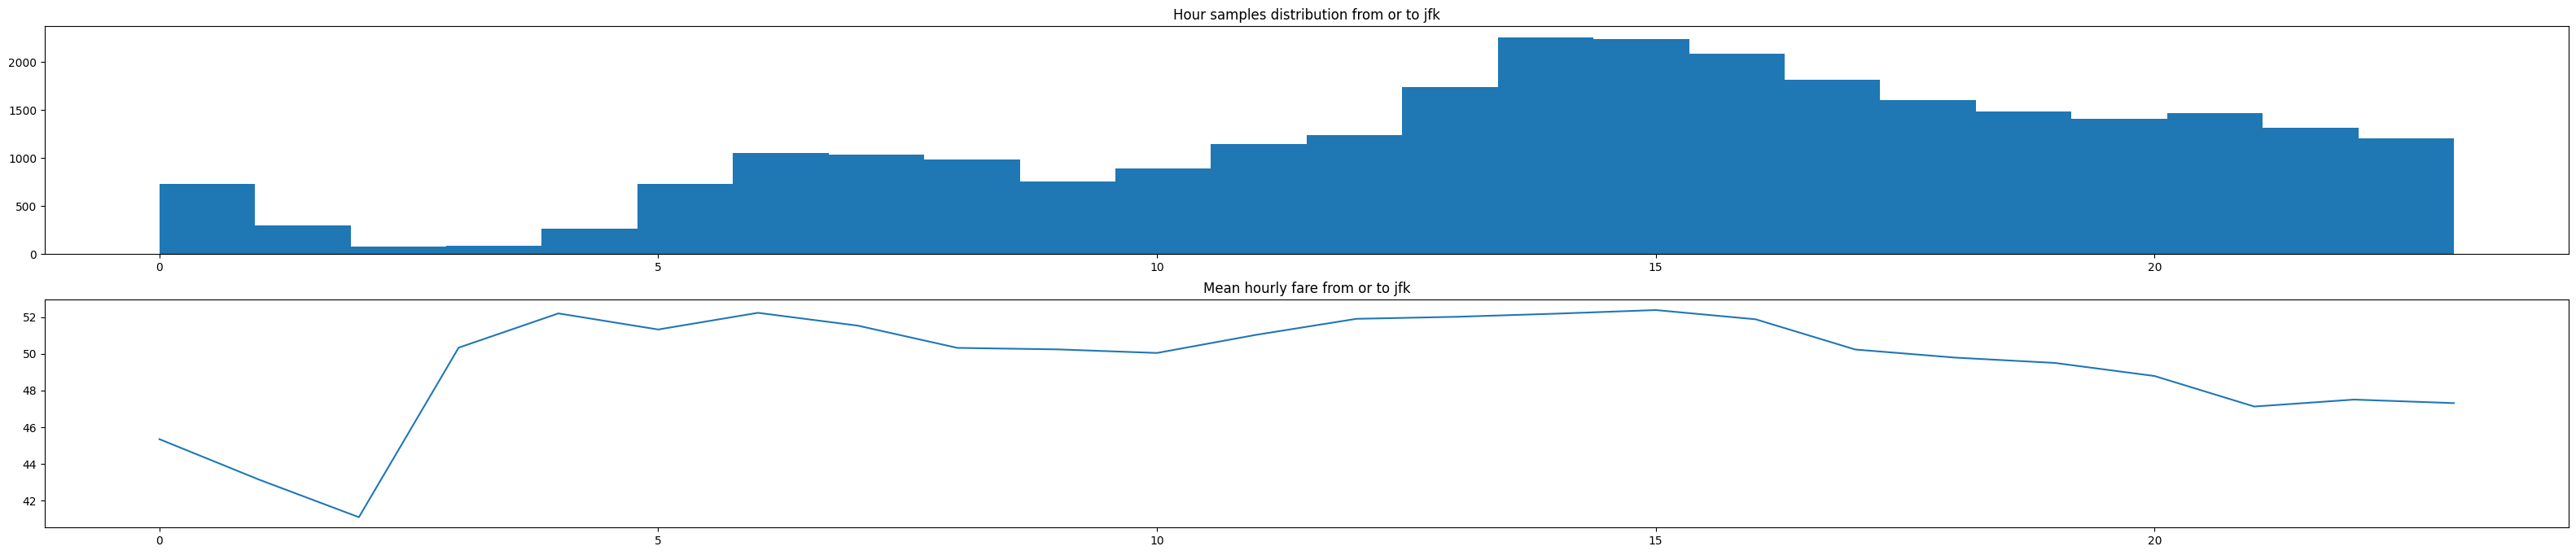

In [28]:
jfk_position = (40.653005, -73.797447)
manhattan_position = (40.722433, -74.000845)
precision = 0.01

df_grt_2013 = df.filter((pl.col('pickup_datetime').is_between(pl.datetime(2013, 1, 1), pl.datetime(2100, 1, 1))))
df_grt_2013 = df_grt_2013.with_column(pl.col("pickup_datetime").dt.hour().alias('pickup_hour'))

df_manhattan = df_grt_2013.filter(((pl.col('pickup_latitude').is_between(manhattan_position[0] - precision, manhattan_position[0] + precision, closed='both')) &
                                 (pl.col('pickup_longitude').is_between(manhattan_position[1] - precision, manhattan_position[1] + precision, closed='both'))) |
                                 ((pl.col('dropoff_latitude').is_between(manhattan_position[0] - precision, manhattan_position[0] + precision, closed='both')) &
                                 (pl.col('dropoff_longitude').is_between(manhattan_position[1] - precision, manhattan_position[1] + precision, closed='both'))))

df_jfk = df_grt_2013.filter(((pl.col('pickup_latitude').is_between(jfk_position[0] - precision, jfk_position[0] + precision, closed='both')) &
                                 (pl.col('pickup_longitude').is_between(jfk_position[1] - precision, jfk_position[1] + precision, closed='both'))) |
                                 ((pl.col('dropoff_latitude').is_between(jfk_position[0] - precision, jfk_position[0] + precision, closed='both')) &
                                 (pl.col('dropoff_longitude').is_between(jfk_position[1] - precision, jfk_position[1] + precision, closed='both'))))


print(f"Number of samples from or to jfk: {len(df_jfk)}")
print(f"Number of samples from or to manhattan: {len(df_manhattan)}")

fg, axs = plt.subplots(2,1, figsize=(40, 8))
axs[0].hist(df_manhattan['pickup_hour'], bins=24)
axs[0].title.set_text('Hour samples distribution from or to manhattan')

axs[1].plot(
    *df_manhattan.select(['pickup_hour', 'fare_amount'])
    .groupby('pickup_hour')
    .agg(pl.mean('fare_amount'))
    .sort('pickup_hour')
    .get_columns())
axs[1].title.set_text("Mean hourly fare from or to manhattan")

plt.show()

fg, axs = plt.subplots(2,1, figsize=(40, 8))

axs[0].hist(df_jfk['pickup_hour'], bins=24)
axs[0].title.set_text('Hour samples distribution from or to jfk')

axs[1].plot(
    *df_jfk.select(['pickup_hour', 'fare_amount'])
    .groupby('pickup_hour')
    .agg(pl.mean('fare_amount'))
    .sort('pickup_hour')
    .get_columns())
axs[1].title.set_text("Mean hourly fare from or to jfk")

plt.show()

(0.12310879999999998, 0.0936020774655418) 3755921


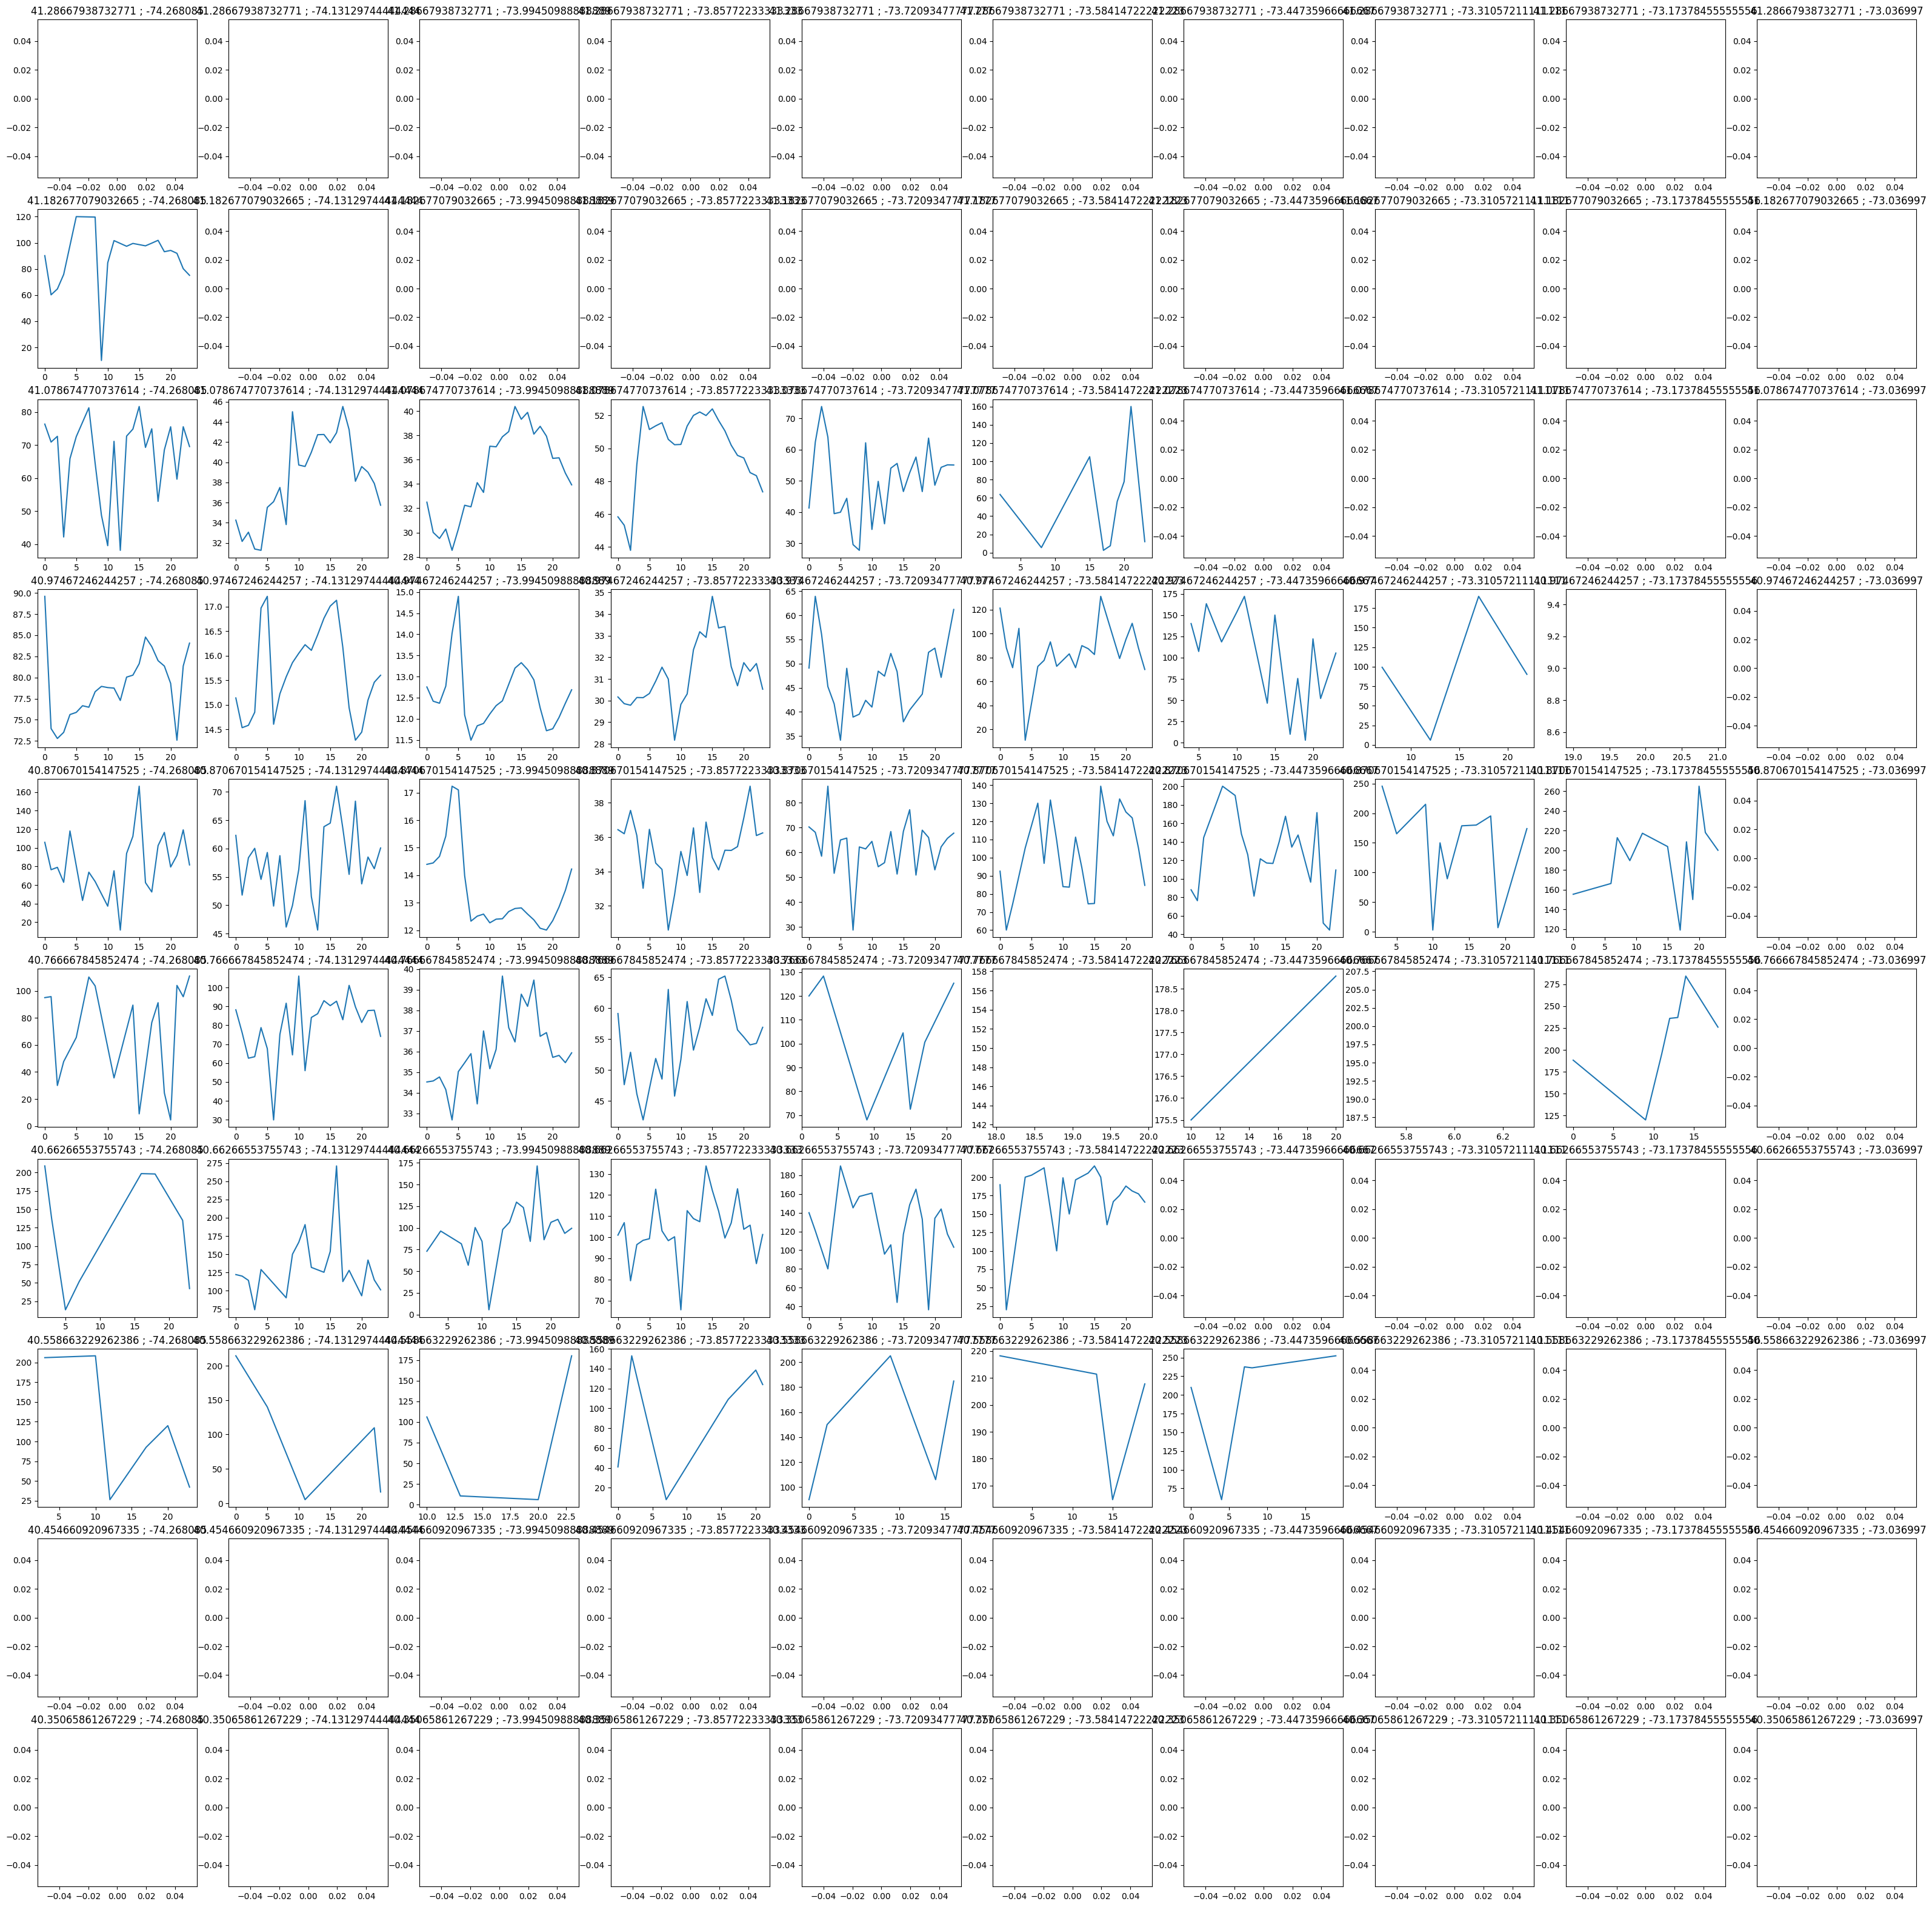

In [29]:
blocks = 10

block_size = (points_area[1]-points_area[0])/blocks , (points_area[3]-points_area[2])/blocks

print(block_size, len(df_grt_2013))

fig, axs = plt.subplots(blocks, blocks, figsize=(40,40))

for ii, i in enumerate(np.linspace(points_area[0], points_area[1], blocks)):
    for jj, j in enumerate(np.linspace(points_area[2], points_area[3], blocks)):
        #print(j,j+block_size[1], i, i+block_size[0])
        df_block = df_grt_2013.filter(((pl.col('pickup_latitude').is_between(j,j+block_size[1], closed='both')) &
                                 (pl.col('pickup_longitude').is_between(i,i+block_size[0], closed='both'))) |
                                 ((pl.col('dropoff_latitude').is_between(j,j+block_size[1], closed='both')) &
                                 (pl.col('dropoff_longitude').is_between(i,i+block_size[0], closed='both'))))
        axs[jj,ii].plot(
            *df_block.select(['pickup_hour', 'fare_amount'])
            .groupby('pickup_hour')
            .agg(pl.mean('fare_amount'))
            .sort('pickup_hour')
            .get_columns())
        axs[blocks-jj-1,ii].title.set_text(f"{j} ; {i}")
        

In [ ]:
import importlib
importlib.reload(data)

<module 'taxifare.data' from '/home/ballman/code/py/taxi/taxifare/data.py'>

# References
*TODO: properly cite?*

[2]: Why Subway and Bus Fares Are Likely to Rise Next Year, https://www.nytimes.com/2022/12/19/nyregion/why-subway-and-bus-fares-are-likely-to-rise-next-year.html

[3]: Fare and Lease Cap Report: April 2013, https://a860-gpp.nyc.gov/concern/nyc_government_publications/jm214q472?locale=en

[4]: norta - code for New Orleans Regional Transit Authority Data, https://git.bryanbrattlof.com/norta/about/

[5]: The Best Time of Year to Visit NYC, https://www.halfhalftravel.com/travel-guides/best-time-to-visit-nyc.html